| **Chapter**                   | 7:  Temporal dynamics of epidemics                    |
| ----------------------------- | ----------------------------------------------------- |
| **Computational Note**        | 7.x: Bayesian changepoint detection with PyMC3        |
| **Package prerequisites**     | [PyMC3](https://docs.pymc.io/en/v3/)                  |


# Bayesian changepoint detection with PyMC3

Changepoint detection looks at a point in time series where a significant change occurs. In this notebook, we are applying Bayesian changepoint detection to an annualised time series of measles incidence. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as arz

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [2]:
%load_ext watermark
%watermark --iversions -v -a "Chris von Csefalvay" -gu "chrisvoncsefalvay" -p theano

Author: Chris von Csefalvay

Github username: chrisvoncsefalvay

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.4.0

theano: 1.1.2

arviz     : 0.11.2
seaborn   : 0.11.2
matplotlib: 3.5.2
numpy     : 1.21.6
pymc3     : 3.11.2
pandas    : 1.4.2



## Loading the data

In [3]:
measles_incidence = pd.read_csv("tycho_20220110-131927.csv", 
                            low_memory=False,
                            parse_dates=["PeriodEndDate"],
                            index_col=["PeriodEndDate"]).groupby("PeriodEndDate").sum()[["CountValue"]]
measles_incidence = measles_incidence[(measles_incidence.index >= "1930-01-01") & (measles_incidence.index < "2000-01-01")]

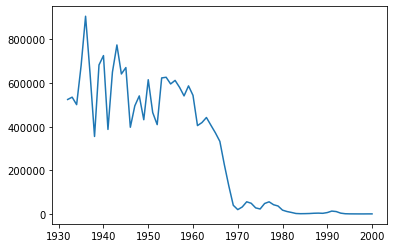

In [4]:

measles_incidence = measles_incidence.resample("Y").sum().rolling(2).mean()

plt.plot(measles_incidence)

In [5]:
measles_incidence.index = measles_incidence.index.map(lambda x: (float(x.strftime("%j"))-1) / 366 + float(x.strftime("%Y"))).to_numpy()

In [6]:
measles_incidence.dropna(inplace=True)
measles_incidence["year"] = np.ceil(measles_incidence.index)

## Defining the model

We assume (against what is pretty evident from the plot above) that the change in measles incidence could have happened in any year between 1930 and 2000. In other words, we assume that the change point $x$ is drawn from a uniform distribution

$$ x \sim \operatorname{Uniform}(1930, 2000) $$

The change point $x$ bisects the time span from 1930 to 2000 into two regimes (see [this paper](https://pages.uoregon.edu/jpiger/research/published-papers/piger_2009_ecss.pdf)'s first few pages for an explanation of what regimes are), which we will very imaginatively call 'before' and 'after'.

Each of these regimes has a mean, $\mu_{before}$ and $\mu_{after}$. We will assume that these are drawn from the same exponential distribution, namely

$$ \mu_{\text{before}} \sim \operatorname{Exp}(\hat{\mu}) $$

and

$$ \mu_{\text{after}} \sim \operatorname{Exp}(\hat{\mu}) $$

$\hat{\mu}$ is the variable `hypermu`, which is the hyperparameter mean or 'starting point' for the distribution. We obtain `hypermu` by taking the inverse of the mean of all cases. The incidence of measles is then a Poisson process of 

$$ I_t \sim \operatorname{Poisson}(r_t) $$

where $r_t$ is drawn from $\mu_{before}$ if $t \leq x$ else drawn from $\mu_{after}$. We use Theano's `math.switch` functionality for this.

In [7]:
hypermu = 1/measles_incidence.CountValue.mean()

In [8]:
with pm.Model() as measles_model:
    change_point = pm.Uniform("change_point", 
                                      lower=1930, 
                                      upper=2000, 
                                      testval=1950)

    MCPY_before = pm.Exponential("MCPY_before", hypermu)
    MCPY_after = pm.Exponential("MCPY_after", hypermu)

    regime = pm.math.switch(change_point >= measles_incidence.year.values, MCPY_before, MCPY_after)

    cases = pm.Poisson("cases", regime, observed=measles_incidence.CountValue.values)

We run this model over eight chains.

In [9]:
with measles_model:
    step = pm.Slice()
    trace = pm.sample(step=step, draws=5000, return_inferencedata=False, chains=8)

Multiprocess sampling (8 chains in 4 jobs)
CompoundStep
>Slice: [MCPY_after]
>Slice: [MCPY_before]
>Slice: [change_point]


Sampling 8 chains for 1_000 tune and 5_000 draw iterations (8_000 + 40_000 draws total) took 64 seconds.


The trace plot is our best tool to initially assess our results. In the left column are the distributions of the values we elicited, while the right column shows the values from each sample. In a good result, the latter ought to look like white noise. Note that the model fixed the change point $x$ to be, with more or less equal likelihood, anytime in the year 1967. 

Note also the dramatic difference this change has made: the mean number of cases before the change was around 537,200 -- the same mean number of cases after the change point was around 19,650 -- a 27.3-fold decrease!

/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'change_point'}>,
        <AxesSubplot:title={'center':'change_point'}>],
       [<AxesSubplot:title={'center':'MCPY_before'}>,
        <AxesSubplot:title={'center':'MCPY_before'}>],
       [<AxesSubplot:title={'center':'MCPY_after'}>,
        <AxesSubplot:title={'center':'MCPY_after'}>]], dtype=object)

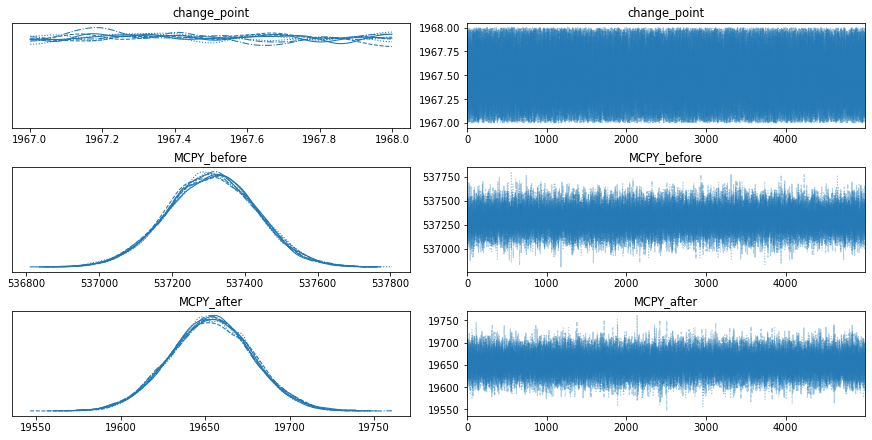

In [10]:
arz.plot_trace(arz.convert_to_dataset(trace))

In [11]:
fig = plt.figure(facecolor="w", figsize=(12, 12), dpi=1200)
ax1 = fig.add_subplot(411, axisbelow=True)

MCPY_before, MCPY_after = pd.DataFrame([trace.get_values("MCPY_before")]).T[0].mean(), pd.DataFrame([trace.get_values("MCPY_after")]).T[0].mean()
changepoint = pd.DataFrame([trace.get_values("change_point")]).T[0].mean()
stdev_before, stdev_after = pd.DataFrame([trace.get_values("MCPY_before")]).T[0].std(), pd.DataFrame([trace.get_values("MCPY_after")]).T[0].std()

ax1.plot(measles_incidence.year, measles_incidence.CountValue, color=COLORS["I"], alpha=0.5, lw=2)
ax1.vlines(x=changepoint, ymin=measles_incidence.CountValue.min(), ymax=measles_incidence.CountValue.max(), color=COLORS["R"], linestyle="--")

ax1.hlines(y=MCPY_before, xmin=measles_incidence.year.min(), xmax=changepoint, colors=COLORS["X"], lw=1)
ax1.axvspan(measles_incidence.year.min(), changepoint, color=COLORS["X"], alpha=0.2)
ax1.hlines(y=MCPY_after, xmin=changepoint, xmax=measles_incidence.year.max(), colors=COLORS["Y"], lw=1)
ax1.axvspan(changepoint, measles_incidence.year.max(), color=COLORS["Y"], alpha=0.2)

ax1.annotate(xy=(changepoint + 0.3, MCPY_before - 16000), text="Pre-change mean", color=COLORS["X"])
ax1.annotate(xy=(changepoint - 10, MCPY_after - 16000), text="Post-change mean", color=COLORS["Y"])

ax1.set_xlim(1932, 2000)
ax1.set_xlabel("Year")
ax1.set_ylabel("Cases per year")


ax2 = fig.add_subplot(412, axisbelow=True)
ax2.plot(pd.DataFrame([trace.get_values("change_point")]).T[0], color=COLORS["R"], alpha=0.7)
ax2.set_ylabel("Changepoint")
ax2.set_xlabel("Sample")


ax3 = fig.add_subplot(413, axisbelow=True)
ax3.plot(pd.DataFrame([trace.get_values("MCPY_before")]).T[0], color=COLORS["X"], alpha=0.7)
ax3.set_ylabel("Pre-change mean")
ax3.set_xlabel("Sample")


ax4 = fig.add_subplot(414, axisbelow=True)
ax4.plot(pd.DataFrame([trace.get_values("MCPY_after")]).T[0], color=COLORS["Y"], alpha=0.7)
ax4.set_ylabel("Post-change mean")
ax4.set_xlabel("Sample")

fig.tight_layout(pad=3.0)

fig.savefig("baye sian_changepoint_detection.pdf")